# test_EDContact_BoxBowl, modified from [test_ContactVolumes](./test_ContactVolumes.ipynb)
For instructions on how to run these tutorial notebooks, please see the [index](./index.ipynb).

If you are not familiar with Drake's hydroelastic contact, study [hydroelastic_contact_basics.ipynb](./hydroelastic_contact_basics.ipynb). You can also find more information in Hydroelastic Contact User Guide [here.](https://drake.mit.edu/doxygen_cxx/group__hydroelastic__user__guide.html)

## Import

In [ ]:
import numpy as np
import os
from pathlib import Path
from IPython.display import Code

from pydrake.common import MemoryFile
from pydrake.geometry import (
    ConvertVolumeToSurfaceMesh, InMemoryMesh, Mesh, MeshSource,
    Rgba, Sphere, StartMeshcat, SurfaceTriangle, TriangleSurfaceMesh,
    _MakeTriangleFromPolygonMesh, _MakeTriangleFromPolygonMeshWithCentroids)
from pydrake.math import RigidTransform
from pydrake.multibody.meshcat import ContactVisualizer, ContactVisualizerParams
from pydrake.multibody.parsing import PackageMap, Parser
from pydrake.multibody.plant import AddMultibodyPlant, MultibodyPlantConfig
from pydrake.multibody.tree import SpatialInertia
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.visualization import ApplyVisualizationConfig, ModelVisualizer, VisualizationConfig

## Start MeshCat

See the section [Viewing models](./authoring_multibody_simulation.ipynb#Viewing-models) in the tutorial [Authoring a Multibody Simulation](./authoring_multibody_simulation.ipynb) for an introduction to MeshCat.

In [ ]:
# Start the visualizer. The cell will output an HTTP link after the execution.
# Click the link and a MeshCat tab should appear in your browser.
meshcat = StartMeshcat()

## Create compliant-hydroelastic yellow box and white bowl

Calculate inertial properties of a 1kg box of size 4x4x4 centimeters.

In [ ]:
from pydrake.multibody.tree import SpatialInertia

spatial_inertia = SpatialInertia.SolidBoxWithMass(
          mass=1, lx=0.04, ly=0.04, lz=0.04)
mass = spatial_inertia.get_mass()
center_of_mass = spatial_inertia.get_com()
matrix6 = spatial_inertia.CopyToFullMatrix6()

print(f"mass = {mass}\n")
print(f"p_PScm = center of mass = {center_of_mass}\n")
print(f"I_SP = rotational inertia = \n{matrix6[:3, :3]}\n")

In [ ]:
yellow_box_str =f"""
<?xml version="1.0"?>
<sdf version="1.7" xmlns:drake="drake.mit.edu">
  <model name="yellow_box">
    <link name="yellow_box">
      <inertial>
        <pose>0 0 0 0 0 0</pose>
        <mass>1</mass>
        <inertia>
          <ixx>0.00026667</ixx><ixy>0</ixy><ixz>0</ixz>
          <iyy>0.00026667</iyy><iyz>0</iyz>
          <izz>0.00026667</izz>
        </inertia>
      </inertial>
      <visual name="visual">
        <geometry>
          <box>
            <size>0.04 0.04 0.04</size>
          </box>
        </geometry>
        <material>
          <diffuse>1.0 1.0 0.0 0.5</diffuse>
        </material>      
      </visual>
      <collision name="collision">
        <geometry>
          <mesh>
            <!-- In this prototype, we need VTK tetrahedral meshes -->
            <uri>package://drake/tutorials/cube.vtk</uri>
            <scale>1 1 1</scale>
          </mesh>
        </geometry>
        <drake:proximity_properties>
          <drake:compliant_hydroelastic/>
          <drake:hydroelastic_modulus>5.0e4</drake:hydroelastic_modulus>
          <drake:hunt_crossley_dissipation>10</drake:hunt_crossley_dissipation>
          <drake:mu_dynamic>0.5</drake:mu_dynamic>
          <drake:mu_static>1.0</drake:mu_static>
        </drake:proximity_properties>
      </collision>
    </link>
    <frame name="origin">
      <pose relative_to="yellow_box">0 0 0 0 0 0</pose>
    </frame>
  </model>
</sdf>
"""

In [ ]:
bowl_url = "package://drake_models/dishes/evo_bowl_compliant.urdf"
bowl_str = Path(PackageMap().ResolveUrl(bowl_url)).read_text(encoding="utf-8")

### Deactivate test mode

In [ ]:
test_mode = False
if test_mode:
    bowl_str = bowl_str.replace("evo_bowl_fine44k.vtk", 
                                "evo_bowl_coarse3k.vtk")

## Create Diagram of the scene and set up visualization

The function `add_scene()` below will create a scene using the assets that we created. It will use `Parser` to add the URDF and SDFormat strings into the scene.

The function `add_viz()` below will create visualization. First we will call `ApplyVisualizationConfig()` to visualize our assets. At this step we will set `publish_contacts=False`, so we can customize contact visualization afterwards. 

To visualize contact result, we will add `ContactVisualizer` with `newtons_per_meter= 20` and `newtons_meters_per_meter= 0.1`. It will draw a red arrow of length 1 meter for each force of 20 newtons and a blue arrow of length 1 meter for each torque of 0.1 newton\*meters.

In [ ]:
initial_bowl_pose_X_WB = RigidTransform(p=[0, 0, 0.025])
initial_yellow_box_pose_X_WB = RigidTransform(p=[0.0, 0, 0])

def add_scene(time_step):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlant(
        MultibodyPlantConfig(
            time_step=time_step,
            discrete_contact_approximation="lagged"),
        builder)
    parser = Parser(plant)

    # Load the assets that we created.
    parser.AddModels(file_contents=yellow_box_str, file_type="sdf")
    parser.AddModels(file_contents=bowl_str, file_type="urdf")
    

    # Finalize the plant after loading the scene.
    plant.Finalize()

    plant.SetDefaultFreeBodyPose(
        plant.GetBodyByName("bowl"),
        initial_bowl_pose_X_WB)
    plant.SetDefaultFreeBodyPose(
        plant.GetBodyByName("yellow_box"),
        initial_yellow_box_pose_X_WB)

    return builder, plant, scene_graph

def add_viz(builder, plant):
    ApplyVisualizationConfig(
        builder=builder, meshcat=meshcat,
        config=VisualizationConfig(
                 default_proximity_color=Rgba(r=0.8, g=0.8, b=0.8, a=0.5),
                 publish_contacts=False))    
    ContactVisualizer.AddToBuilder(
        builder=builder, plant=plant, meshcat=meshcat,
        params=ContactVisualizerParams(
                 newtons_per_meter=20,
                 newton_meters_per_meter= 0.1))

## Set initial poses in the `context`

In [ ]:
# Clear MeshCat window from the previous blocks.
meshcat.Delete()
meshcat.DeleteAddedControls()

time_step = 1e-2
builder, plant, scene_graph = add_scene(time_step)
add_viz(builder, plant)

diagram = builder.Build()
diagram_context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(diagram_context)

diagram_context.SetTime(0)
plant.SetFreeBodyPose(plant_context,
                      plant.GetBodyByName("bowl"),
                      initial_bowl_pose_X_WB)
plant.SetFreeBodyPose(plant_context,
                      plant.GetBodyByName("yellow_box"),
                      initial_yellow_box_pose_X_WB)
diagram.ForcedPublish(diagram_context)

### Call ComputeContactVolumes() and print the results

In [ ]:
inspector = scene_graph.model_inspector()
query_object = scene_graph.get_query_output_port().Eval(
    scene_graph.GetMyContextFromRoot(diagram_context))
contact_volumes = query_object.ComputeContactVolumes()

print(f"Number of contact volume = {len(contact_volumes)}")
print()

def PrintContactSurface(s, inspector):
  print(f"id_M()={s.id_M()}")
  print(f"id_N()={s.id_N()}")
  print(f"inspector.GetName(id_M())={inspector.GetName(s.id_M())}")
  print(f"inspector.GetName(id_N())={inspector.GetName(s.id_N())}")
  print(f"num_faces()={s.num_faces()}")  
  print(f"num_vertices()={s.num_vertices()}")  
  print(f"total_area()={s.total_area()}")  
  print(f"centroid()={s.centroid()}")  
  print(f"is_triangle()={s.is_triangle()}")  
  print(f"representation()={s.representation()}")  
  print(f"HasGradE_M()={s.HasGradE_M()}")  
  print(f"HasGradE_N()={s.HasGradE_N()}")
  print(f"HasCentroidalValue()={s.HasCentroidalValue()}")  
  print()  

print("contact_volumes[0][0]:")
PrintContactSurface(contact_volumes[0][0], inspector)

print("contact_volumes[0][1]:")
PrintContactSurface(contact_volumes[0][1], inspector)

### Draw collision meshes

In [ ]:
meshcat.SetProperty("illustration", "visible", False)
meshcat.SetProperty("contact_forces",  "visible", False)
meshcat.SetProperty("proximity", "visible", False)
meshcat.SetProperty("/Grid", "visible", False)
meshcat.SetProperty("/Axes", "visible", False)

all_ids = inspector.GetAllGeometryIds()
for id in all_ids:
  if inspector.GetName(id) == "yellow_box::collision" :
    yellow_box_id = id
  if inspector.GetName(id) == "bowl::collision" :
    bowl_id = id
    
yellow_box_mesh = ConvertVolumeToSurfaceMesh(
    inspector.maybe_get_hydroelastic_mesh(yellow_box_id))
print(f"yellow_box_mesh.num_vertices() = {yellow_box_mesh.num_vertices()}\n")

bowl_mesh = ConvertVolumeToSurfaceMesh(
    inspector.maybe_get_hydroelastic_mesh(bowl_id))
print(f"bowl_mesh.num_vertices() = {bowl_mesh.num_vertices()}\n")

def DrawCollisionMeshInOneColorWithBlackEdges(name, id, mesh, surface_rgba):
  meshcat.SetTransform(f"{name}", query_object.GetPoseInWorld(id))
  meshcat.SetObject(f"{name}/shade", mesh, rgba = surface_rgba,
                    wireframe=False)
  meshcat.SetObject(f"{name}/wireframe", mesh, rgba=Rgba(0, 0, 0, 1),
                    wireframe=True, wireframe_line_width=2.0)

DrawCollisionMeshInOneColorWithBlackEdges(
 "YellowBoxMesh", yellow_box_id, yellow_box_mesh,
 Rgba(0.8, 0.8, 0, 0.5))
DrawCollisionMeshInOneColorWithBlackEdges(
 "BowlMesh", bowl_id, bowl_mesh,
 Rgba(1, 1, 1, 1))

### Draw contact volumes
We can't draw polygonal meshes, so we triangulate the polygons around their centroids.

In [ ]:
def BoundaryNameOfContactSurface(s, inspector):
  name_M = inspector.GetName(s.id_M())
  name_N = inspector.GetName(s.id_N())  
  if s.HasGradE_M() and not s.HasGradE_N():
    mesh_name = f"{name_N}_IN_{name_M}"
  if not s.HasGradE_M() and s.HasGradE_N():
    mesh_name = f"{name_M}_IN_{name_N}"
  if s.HasGradE_M() and s.HasGradE_N():
    mesh_name = f"Between_{name_M}_and_{name_N}"
  return mesh_name  

def DrawTriangleMesh(name, mesh, rgba):
  meshcat.SetObject(f"{name}/shade", mesh, rgba = rgba, wireframe=False,
                               wireframe_line_width=3.0)
  meshcat.SetObject(f"{name}/wireframe", mesh, rgba = Rgba(0, 0, 0, 1), wireframe=True,
                               wireframe_line_width=3.0)

def TriangleMeshFromContactSurface(s):
  if s.is_triangle():
    triangle_mesh = s.tri_mesh_W()
  else:  
    poly_mesh = s.poly_mesh_W()
    triangle_mesh = _MakeTriangleFromPolygonMeshWithCentroids(poly_mesh)
  return triangle_mesh  
    
    
def DrawContactSurface(s, rgba, inspector):
  mesh_name = BoundaryNameOfContactSurface(s, inspector)  
  print(f"Draw {mesh_name}")
  DrawTriangleMesh(mesh_name, TriangleMeshFromContactSurface(s), rgba)
    
    
DrawContactSurface(contact_volumes[0][0] , Rgba(1, 1, 0, 1), inspector)
DrawContactSurface(contact_volumes[0][1] , Rgba(0.7, 0.7, 0.7, 1), inspector)

### Visualize face normals

In [ ]:
# mesh_M can be a TriangleSurfaceMesh or a PolygonSurfaceMesh.
def DrawFaceNormal(name, mesh_M, rgba):
  # 1mm line  
  kNormalLength = 0.001  
  face_normals_M_list = [mesh_M.face_normal(f)
                         for f in range(mesh_M.num_elements())]
  face_normals_at_vertices_M = np.array(face_normals_M_list).transpose()
  centroids_of_faces_M_list = [mesh_M.element_centroid(f)
                               for f in range(mesh_M.num_elements())]  
  centroids_of_faces_M = np.array(centroids_of_faces_M_list).transpose()
  starts_M = centroids_of_faces_M
  ends_M = starts_M + kNormalLength * face_normals_at_vertices_M
  kRed = Rgba(r=1, g=0, b=0, a=1)
  meshcat.SetLineSegments(f"{name}/face_normals",
                          starts_M, ends_M, line_width=1, rgba=rgba)

def DrawContactFaceNormal(s, rgba, inspector):
  name = f"{BoundaryNameOfContactSurface(s, inspector)}/face_normal"
  print(f"Draw {name}")
  DrawFaceNormal(name, s.poly_mesh_W(), rgba)


kDarkBrown = Rgba(0.39, 0.26, 0.12, 1)
DrawContactFaceNormal(contact_volumes[0][0], kDarkBrown, inspector)
kBlack = Rgba(0, 0, 0, 1)
DrawContactFaceNormal(contact_volumes[0][1], kBlack, inspector)

### Move the yellow box

In [ ]:
meshcat.SetProperty("/Grid", "visible", False)
meshcat.SetProperty("/Axes", "visible", False)

new_yellow_box_pose_X_WB = RigidTransform(p=[0.005, 0, 0])

def HideContactFaceNormal(s, inspector):
  name = f"{BoundaryNameOfContactSurface(s, inspector)}/face_normal"
  meshcat.SetProperty(name, "visible", False)  

def MoveYellowBox(inspector):
  plant.SetFreeBodyPose(plant_context,
                        plant.GetBodyByName("yellow_box"),
                        new_yellow_box_pose_X_WB)
  
  query_object = scene_graph.get_query_output_port().Eval(
      scene_graph.GetMyContextFromRoot(diagram_context))

  contact_volumes = query_object.ComputeContactVolumes()
  DrawCollisionMeshInOneColorWithBlackEdges(
    "YellowBoxMesh", yellow_box_id, yellow_box_mesh,
    Rgba(0.8, 0.8, 0, 0.5))
  DrawCollisionMeshInOneColorWithBlackEdges(
    "BowlMesh", bowl_id, bowl_mesh,
    Rgba(1, 1, 1, 1))
  DrawContactSurface(contact_volumes[0][0] , Rgba(1, 1, 0, 1), inspector)
  DrawContactSurface(contact_volumes[0][1] , Rgba(0.7, 0.7, 0.7, 1), inspector)
  DrawContactFaceNormal(contact_volumes[0][0], kDarkBrown, inspector)
  DrawContactFaceNormal(contact_volumes[0][1], kBlack, inspector)
  # Hide the face normals to reduce clutters  
  HideContactFaceNormal(contact_volumes[0][0], inspector) 
  HideContactFaceNormal(contact_volumes[0][1], inspector) 
    
MoveYellowBox(inspector)

In [ ]:
new_yellow_box_pose_X_WB = RigidTransform(p=[0.010, 0, 0.0])

MoveYellowBox(inspector)

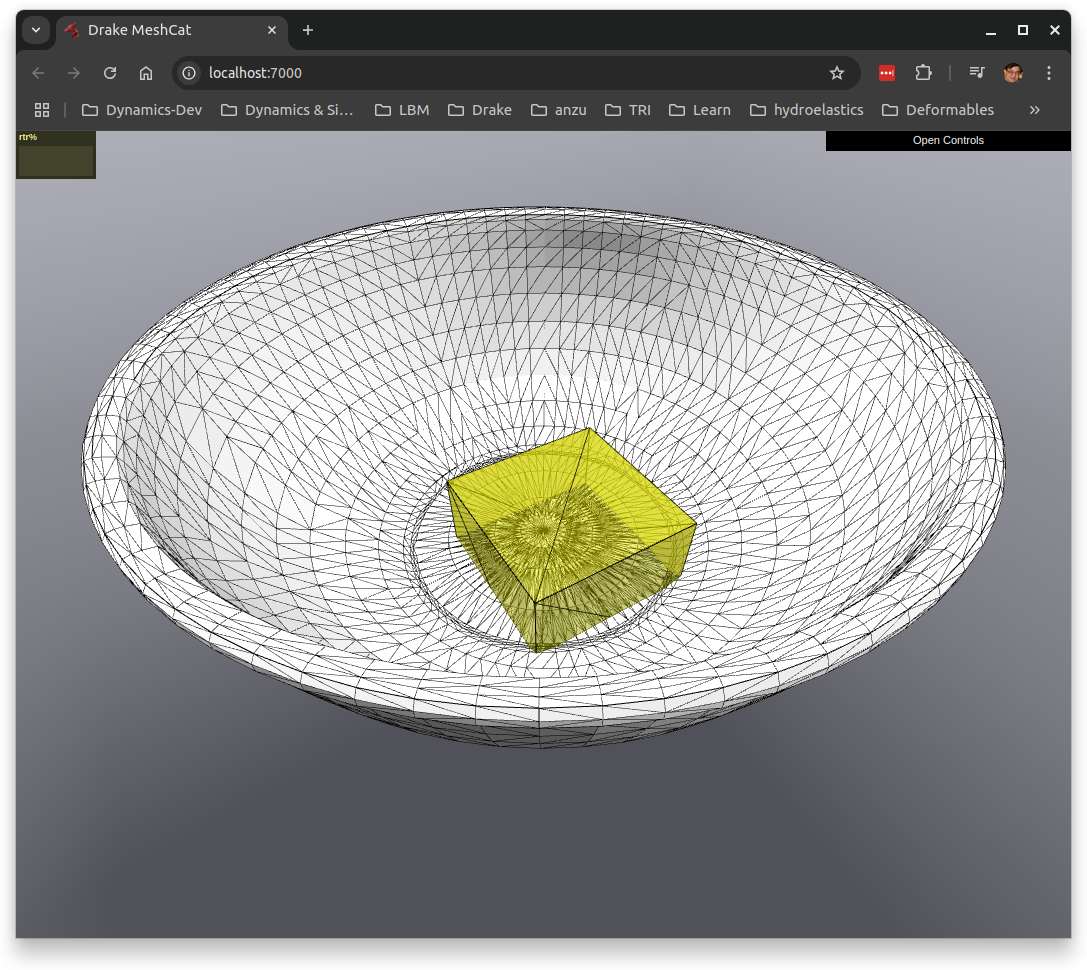

### Show only the contact volume

In [ ]:
meshcat.SetProperty("YellowBoxMesh", "visible", False)
meshcat.SetProperty("BowlMesh", "visible", False)

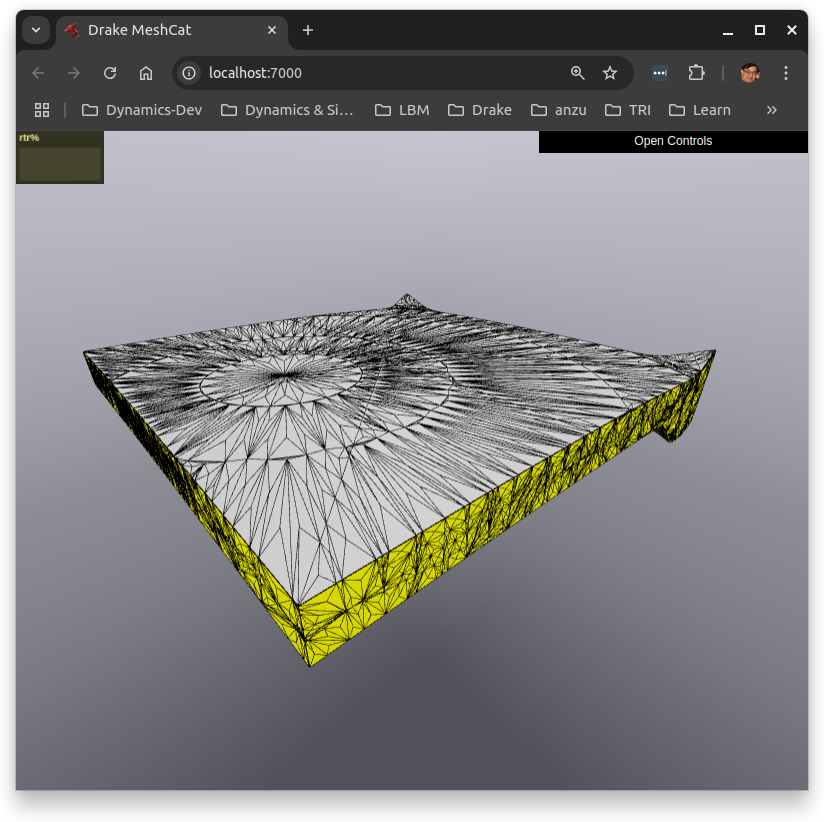

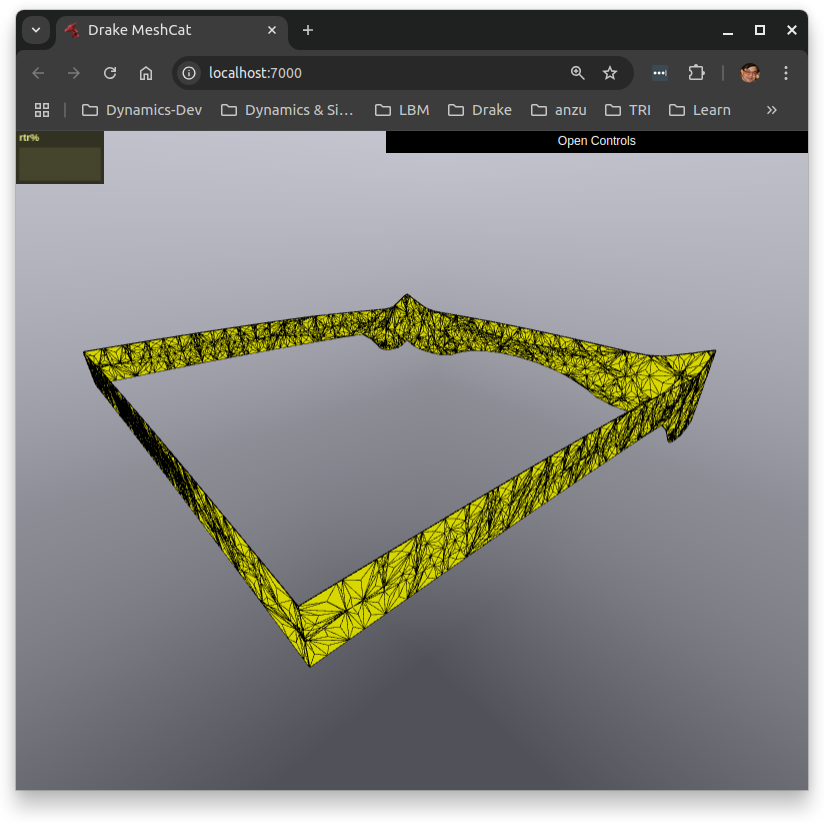

## Download simulation result into a html file for sharing

You can download the simulation result into a self-contained html file, allowing others to playback the simulated results without simulating. The following code prints the URL for downloading. Click on the printed URL to download.

In [ ]:
print(f"{meshcat.web_url()}/download")